# TP3

### Partie I : Découverte de Deutsch Josza

Run & Test effectifs

In [149]:
from qiskit import *
import qiskit.visualization as viz
import qiskit.quantum_info as quantum_info
from qiskit.circuit.gate import Gate
import numpy as np

Création d'une classe générique pour plus de : 

* Lisibilité

* Contrôle des erreurs

* Généralisation du code et des principes de la technique

### Deutsch Jozsa généralisé

(Répond à la question 3, et sera utilisé pour répondre aux autres questions)

In [150]:
class CustomCircuit():
    def __init__(self, circuit):
        self.circuit = circuit

    def __call__(self):
        return self.circuit

    def run(self):
        """
        runs the circuit and returns a standard result object
        """
        simulator = Aer.get_backend('statevector_simulator')
        job = execute(self.circuit, simulator, shots=1024)

        # Get the results
        result = job.result()
        return result

    def counts(self):
        result = self.run()
        return result.get_counts()

    def draw(self):
        """
        pretty graphing method
        """
        return self.circuit.draw(output='mpl')
    
    def vizcounts(self):
        return viz.plot_histogram(self.counts())

class DeutschJozsa(CustomCircuit):
    def __init__(self, n, oracle):
        """
        builds the deutsch_jozsa circuit using the oracle building function
        """
        self.circuit = QuantumCircuit(n+1, n)

        # Portes hadamard
        for i in range(n):
            self.circuit.h(i)

        # last qbit
        self.circuit.x(n)
        self.circuit.h(n)

        # inserting oracle
        if isinstance(oracle, Gate):
            self.circuit.append(oracle, range(n + 1)) # applique la porte (en évitant les clbits de mesure)
        elif callable(oracle):
            oracle(self.circuit, n)
        else:
            raise ValueError("oracle must be a function or a qiskit gate")

        # new hadamard column
        for i in range(n):
            self.circuit.h(i)
        
        self.circuit.barrier()

        # measurements
        for i in range(n):
            self.circuit.measure(i, i)

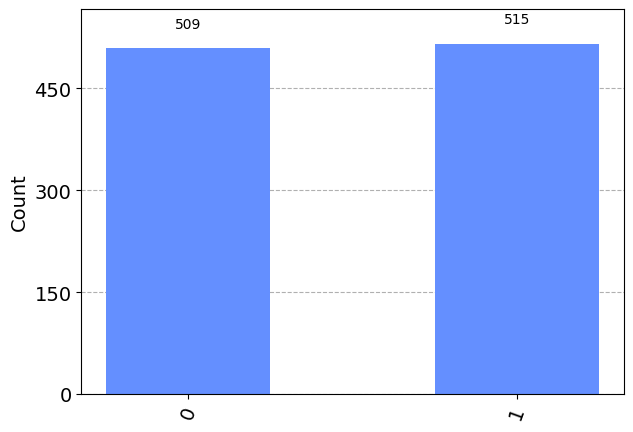

In [151]:
circuit = QuantumCircuit(1, 1)
circuit.initialize([1, 0], 0)
circuit.measure(0, 0)

constant = CustomCircuit(circuit)

circuit = QuantumCircuit(1, 1)
circuit.initialize([1, 0], 0)
circuit.h(0)
circuit.measure(0, 0)

equilibre = CustomCircuit(circuit)

equilibre.vizcounts()

#### Implémentation de Deutsch Jozsa avec un oracle équilibré

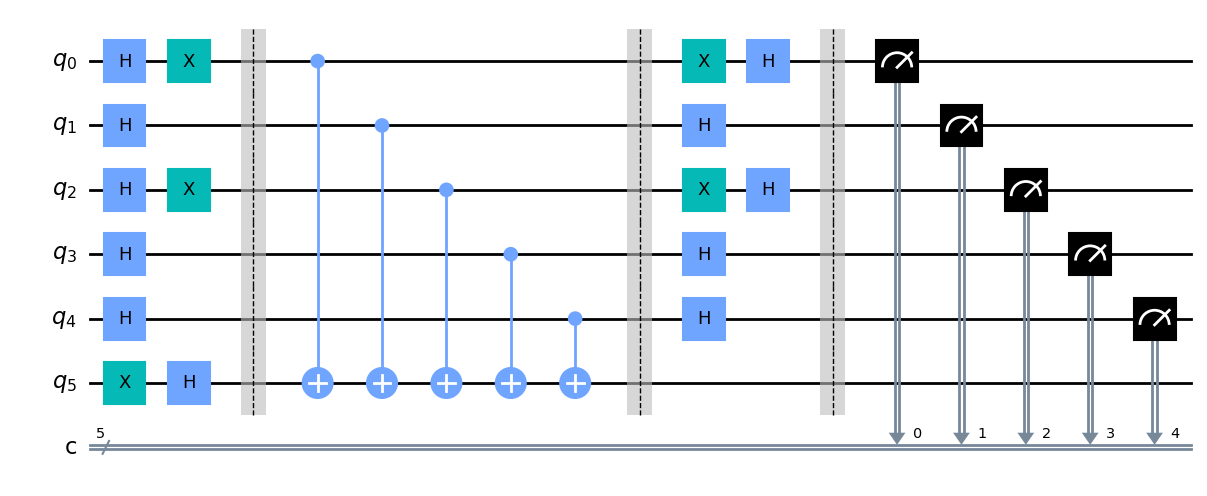

In [152]:
def oracle_equilibre(circ, n):
    assert n > 1
    control = True
    while control:
        b = np.random.randint(1, 2**n)
        b_str = format(b, '0'+str(n)+'b') # random balanced function
        if '0' in b_str and '1' in b_str:
            control = False

    # Portes X
    for i, qbit in enumerate(b_str):
        if qbit == '1':
            circ.x(i)

    circ.barrier()

    for i in range(n): # C nots
        circ.cx(i, n)

    circ.barrier()

    for i, qbit in enumerate(b_str): # Portes X round 2
        if qbit == '1':
            circ.x(i)

equilibre = DeutschJozsa(5, oracle_equilibre)
equilibre.draw()

#### Deutsch Jozsa avec un oracle constant (aucune porte n'est nécessaire)

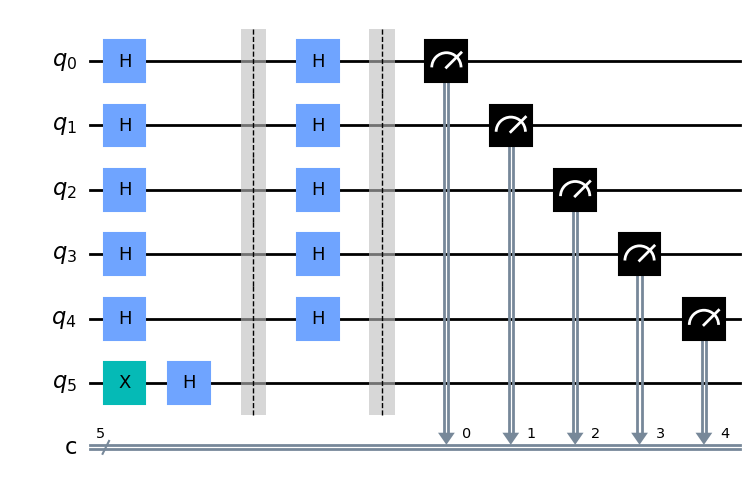

In [153]:
constant = DeutschJozsa(5, lambda circ, n : circ.barrier())
constant.draw()

### Oracles sur quelques Qbits

Dans le cas particulier de l'**oracle équilibré**, une partie des qubits est inversé par les cnot dans l'oracle, le passage par l'oracle est sensé donner un état orthogonal à celui d'avant l'oracle. Quand on applique Hadamard une 2ème fois (pour "annuler" celui d'avant l'oracle) on se retrouve avec l'état orthogonal à l'état de départ |0> (donc |1>)

L'**oracle constant** ne change pas le vecteur d'état, et puisque toutes les opérations hors-oracle du circuit se compensent on se retrouve au final avec l'état de départ, d'où les résultats.

In [154]:
print(
    f"Equilibre : {equilibre.counts()} \n\nConstant : {constant.counts()}"
)

Equilibre : {'11111': 1024} 

Constant : {'00000': 1024}


### Solutions de dj_problem_oracle

Appréhension des données...

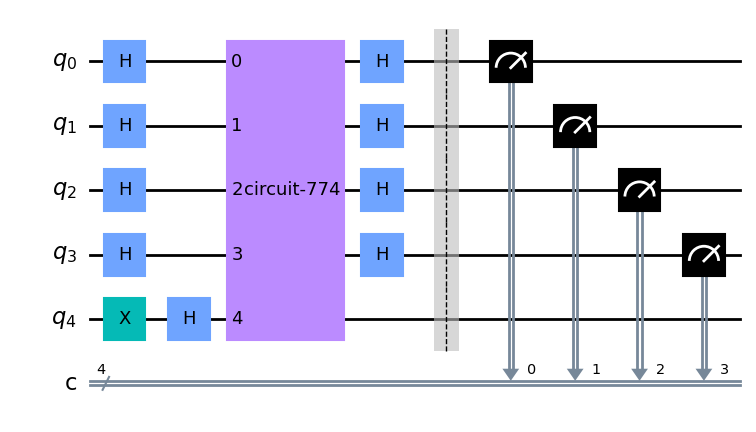

In [155]:
from qiskit_textbook.problems import dj_problem_oracle

# https://quantumcomputing.stackexchange.com/questions/12845/feedback-on-deutsch-josza-alg-homework-prob-in-learning-quantum-computation-us

from qiskit_textbook.problems import dj_problem_oracle
oracle = dj_problem_oracle(1)

circ = DeutschJozsa(oracle.num_qubits - 1, oracle)
circ.draw()

Exécution des circuits pour voir le résultat de Deutsch Josza

In [156]:
num_circuits = 4
for i in range(1, num_circuits + 1):
    oracle = dj_problem_oracle(i)
    circ = DeutschJozsa(oracle.num_qubits - 1, oracle)
    print(f"Oracle {i} : {circ.counts()}")

Oracle 1 : {'1111': 1024}
Oracle 2 : {'0000': 1024}
Oracle 3 : {'0001': 287, '1111': 260, '1101': 244, '0011': 233}
Oracle 4 : {'0100': 1024}


# Partie II : Simon

In [157]:
from qiskit_textbook.tools import simon_oracle

type(simon_oracle('11001'))

qiskit.circuit.quantumcircuit.QuantumCircuit

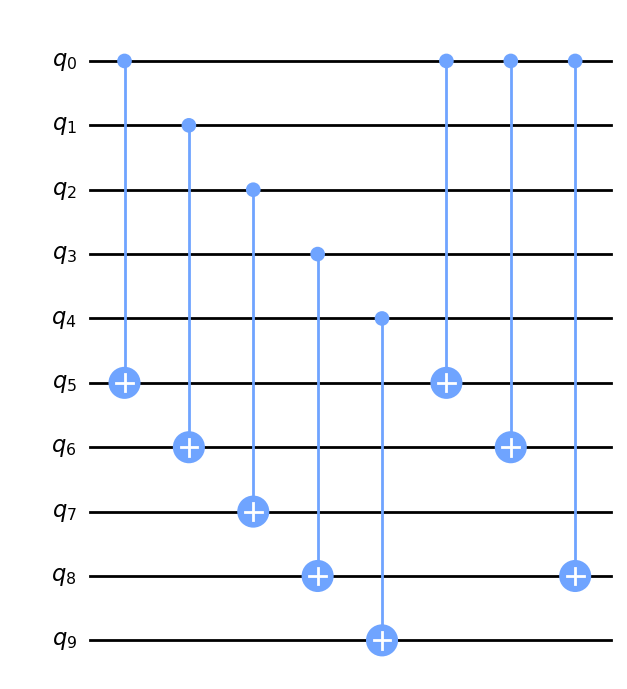

In [158]:
# generating a random bytestring for simon_oracle
n = 5

b = np.random.randint(1, 2**n)
b_str = format(b, '0'+str(n)+'b')

oracle = simon_oracle(b_str)

oracle.draw(output = 'mpl')

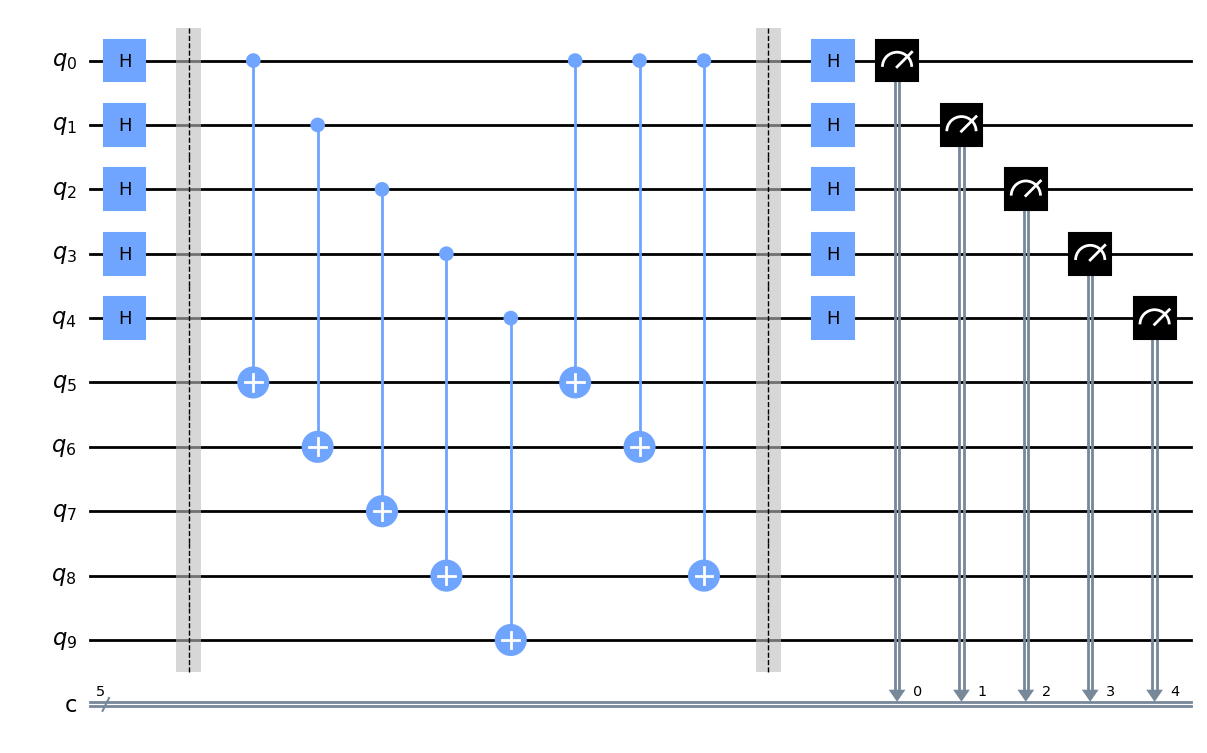

In [159]:
circuit = QuantumCircuit(2*n, n)

circuit.h(range(n))

circuit.barrier()
circuit = circuit.compose(oracle)
circuit.barrier()

circuit.h(range(n))
circuit.measure(range(n), range(n))

interfaced_circuit = DeutschJozsa(circuit.num_qubits - 1, lambda circ, n: None) # we're only using DeutschJozsa's vizualization features
interfaced_circuit.circuit = circuit # replacing the circuit by the one we built

interfaced_circuit.draw()

Le circuit associé à l'oracle de simon est crée, on n'a plus qu'à l'évaluer.

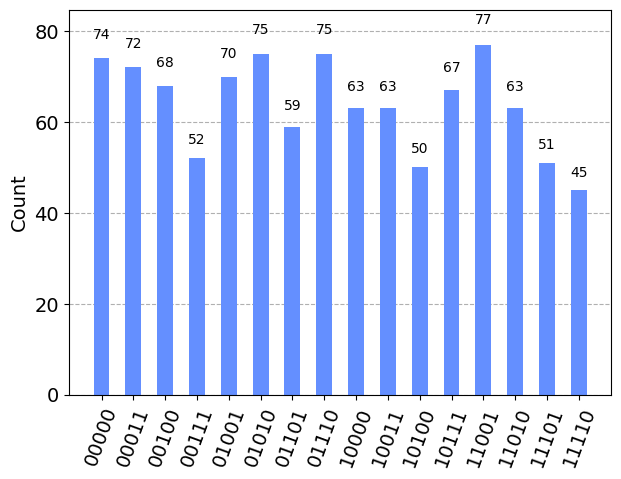

In [161]:
interfaced_circuit.vizcounts()